In [1]:
from pystencils.session import *
import timeit
%load_ext Cython

# Demo: Benchmark numpy, Cython, pystencils

In this notebook we compare and benchmark different ways of implementing a simple stencil kernel in Python.
Our simple example computes the average of the four neighbors in 2D and stores it in a second array. To prevent out-of-bounds accesses, we skip the cells at the border and compute values only in the range `[1:-1, 1:-1]`

## Implementations

The first implementation is a pure Python implementation:

In [2]:
def avg_pure_python(src, dst):       
    for x in range(1, src.shape[0] - 1):
        for y in range(1, src.shape[1] - 1):
            dst[x, y] = (src[x + 1, y] + src[x - 1, y] +
                         src[x, y + 1] + src[x, y - 1]) / 4

Obviously, this will be a rather slow version, since the loops are written directly in Python. 

Next, we use *numpy* functions to delegate the looping to numpy. The first version uses the `roll` function to shift the array by one element in each direction. This version has to allocate a new array for each accessed neighbor.

In [3]:
def avg_numpy_roll(src, dst):
    neighbors = [np.roll(src, axis=a, shift=s) for a in (0, 1) for s in (-1, 1)]
    np.divide(sum(neighbors), 4, out=dst)

Using views, we can get rid of the additional copies:

In [4]:
def avg_numpy_slice(src, dst):
    dst[1:-1, 1:-1] = src[2:, 1:-1] + src[:-2, 1:-1] + \
                      src[1:-1, 2:] + src[1:-1, :-2]

To further optimize the kernel we switch to Cython, to get a compiled C version.

In [5]:
%%cython
import cython

@cython.boundscheck(False)
@cython.wraparound(False)
def avg_cython(object[double, ndim=2] src, object[double, ndim=2] dst):
    cdef int xs, ys, x, y
    xs, ys = src.shape
    for x in range(1, xs - 1):
        for y in range(1, ys - 1):
            dst[x, y] = (src[x + 1, y] + src[x - 1, y] +
                         src[x, y + 1] + src[x, y - 1]) / 4

If available, we also try the numba just-in-time compiler

In [6]:
try:
    from numba import jit

    @jit(nopython=True)
    def avg_numba(src, dst):
        dst[1:-1, 1:-1] = src[2:, 1:-1] + src[:-2, 1:-1] + \
                          src[1:-1, 2:] + src[1:-1, :-2]
except ImportError:
    pass

And finally we also create a *pystencils* version of the same stencil code:

In [7]:
src, dst = ps.fields("src, dst: [2D]")

update = ps.Assignment(dst[0,0], 
                       (src[1, 0] + src[-1, 0] + src[0, 1] + src[0, -1]) / 4)
avg_pystencils = ps.create_kernel(update).compile()

In [8]:
all_implementations = {
    'pure Python': avg_pure_python,
    'numpy roll': avg_numpy_roll,
    'numpy slice': avg_numpy_slice,
    'pystencils': avg_pystencils,
}
if 'avg_cython' in globals():
    all_implementations['Cython'] = avg_cython
if 'avg_numba' in globals():
    all_implementations['numba'] = avg_numba

## Benchmark functions

We implement a short function to get in- and output arrays of a given shape and to measure the runtime.

In [9]:
def get_arrays(shape):
    in_arr = np.random.rand(*shape)
    out_arr = np.empty_like(in_arr)
    return in_arr, out_arr

def do_benchmark(func, shape):
    in_arr, out_arr = get_arrays(shape)
    func(src=in_arr, dst=out_arr) # warmup
    timer = timeit.Timer('f(src=src, dst=dst)', globals={'f': func, 'src': in_arr, 'dst': out_arr})
    calls, time_taken = timer.autorange()
    return time_taken / calls

## Comparison

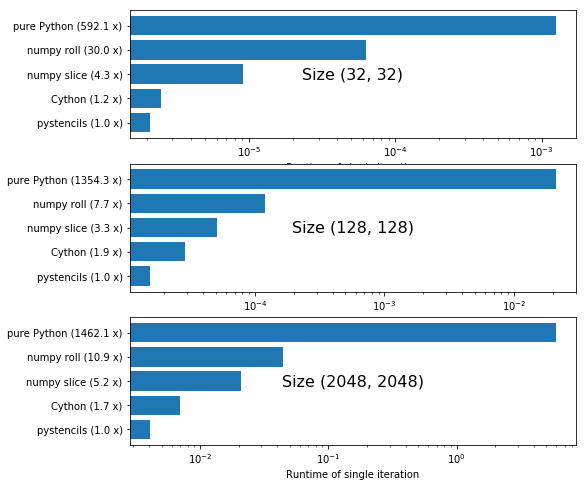

In [10]:
plot_order = ['pystencils', 'Cython', 'numba', 'numpy slice', 'numpy roll', 'pure Python']
plot_order = [p for p in plot_order if p in all_implementations]

def bar_plot(*shape):
    names = plot_order
    runtimes = tuple(do_benchmark(all_implementations[name], shape) for name in names)
    for runtime, name in zip(runtimes, names):
        # assert that pystencils is the fastest
        # if some change degrades performance of pystencils, we see this automatically in CI system
        assert runtime >= runtimes[names.index('pystencils')], "pystencils is slower than " + name
    speedups = tuple(runtime / min(runtimes) for runtime in runtimes)
    y_pos = np.arange(len(names))
    labels = tuple(f"{name} ({round(speedup, 1)} x)" for name, speedup in zip(names, speedups))
    
    plt.text(0.5, 0.5, f"Size {shape}", horizontalalignment='center', fontsize=16,
             verticalalignment='center', transform=plt.gca().transAxes)
    plt.barh(y_pos, runtimes, log=True)
     
    plt.yticks(y_pos, labels);
    plt.xlabel('Runtime of single iteration')
    
plt.figure(figsize=(8, 8))

plt.subplot(3, 1, 1)
bar_plot(32, 32)

plt.subplot(3, 1, 2)
bar_plot(128, 128)

plt.subplot(3, 1, 3)
bar_plot(2048, 2048)

All runtimes are plotted logarithmically. Numbers next to the labels show how much slower the version is than the fastest one.